In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 819kB 4.2MB/s 
     |████████████████████████████████| 276kB 32.3MB/s 
     |████████████████████████████████| 112kB 37.5MB/s 
     |████████████████████████████████| 829kB 36.3MB/s 
     |████████████████████████████████| 10.6MB 20.6MB/s 
     |████████████████████████████████| 645kB 21.6MB/s 
     |████████████████████████████████| 1.3MB 34.6MB/s 
     |████████████████████████████████| 296kB 43.7MB/s 
     |████████████████████████████████| 143kB 45.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=4608ac66900a44e573983859b3d613f253b6f162e818996660fb46176cd073c1
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [ ]:
import os

import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from multiprocessing import Process

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
import gc

py_file_location = '/content/gdrive/My Drive/ao_prediction/conv_lstm'
sys.path.append(os.path.abspath(py_file_location))


In [ ]:
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My Drive/ao_prediction/notebooks', '/content/gdrive/My Drive/ao_prediction/notebooks', '/content/gdrive/My Drive/ao_prediction/conv_lstm']


In [ ]:
from training_seting import opt
from conv_lstm_cell import ConvLSTMCell
from encoder_decoder import  EncoderDecoderConvLSTM
from moving_wavefront import MovingWFLightning

from wavefront_data import WavefrontData

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My Drive/ao_prediction/notebooks', '/content/gdrive/My Drive/ao_prediction/notebooks', '/content/gdrive/My Drive/ao_prediction/conv_lstm', '/content/gdrive/My Drive/ao_prediction/notebooks', '/content/gdrive/My Drive/ao_prediction/notebooks']
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call 

In [ ]:
model = None
gc.collect()
torch.cuda.empty_cache()

path = '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mixed3_100x100.pickle'
train_data = WavefrontData(path, type_f = "PHASE")
val_data = WavefrontData(path,  type_f = "PHASE")
test_data = WavefrontData(path,  type_f = "PHASE")

conv_lstm_model = EncoderDecoderConvLSTM(nf=opt.n_hidden_dim, in_chan=1).to("cuda")
model = MovingWFLightning(model=conv_lstm_model).to("cuda")

history = []
thistory = []
lr_history = []
last_epoch = 0

lr = opt.lr
optimizer =  torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:


optimizer =  torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:

for epoch in range(last_epoch, opt.epochs):
    j = 0
    losses = 0
    tlosses = 0
    jtest = 0
    for i,batch in enumerate(train_data):
        optimizer.zero_grad()
        j+=1
        loss = model.training_step(batch.to("cuda"), i)
        losses+=loss["loss"]
        optimizer.step()
    for k,tbatch in enumerate(test_data):
        test_loss = model.test_step(tbatch.to("cuda"), k)
        jtest+=1
        tlosses+=test_loss["loss"]
        test_loss["loss"].backward()
    thistory.append(tlosses/jtest)
    history.append(losses/j)
    last_epoch = epoch
    lr_history.append(lr)
    print("Epoch %d loss = %f, test loss = %f (count of batch %d)"%(epoch, losses/j, tlosses/jtest, j))
    if losses/j < 0.0001:
        break


Epoch 0 loss = 0.297031, test loss = 0.202958 (count of batch 100)
Epoch 1 loss = 0.194851, test loss = 0.168326 (count of batch 100)
Epoch 2 loss = 0.158624, test loss = 0.176931 (count of batch 100)
Epoch 3 loss = 0.154894, test loss = 0.127797 (count of batch 100)
Epoch 4 loss = 0.138182, test loss = 0.139168 (count of batch 100)
Epoch 5 loss = 0.129001, test loss = 0.126034 (count of batch 100)
Epoch 6 loss = 0.128647, test loss = 0.167360 (count of batch 100)


KeyboardInterrupt: ignored

In [ ]:
import datetime
import pickle

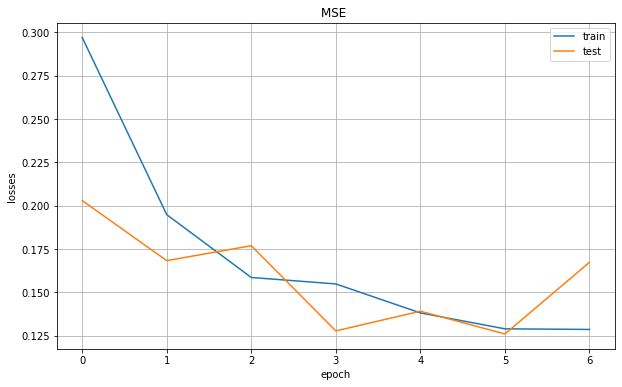

In [ ]:

check_file_hist = os.path.exists('/content/gdrive/My Drive/ao_prediction/history')
check_file_conf = os.path.exists('/content/gdrive/My Drive/ao_prediction/configs')
check_file_model = os.path.exists('/content/gdrive/My Drive/ao_prediction/model')

if not check_file_conf:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/configs")
if not check_file_hist:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/history")
if not check_file_model:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/model")

model_name ="mse_conv_lstm_%d_%d_%d_%d"%(datetime.datetime.now().day,
                                                  datetime.datetime.now().month,
                                                  datetime.datetime.now().hour,
                                                  datetime.datetime.now().minute)
plt.figure(figsize=(10, 6))
plt.plot(history, label="train")
plt.plot(thistory, label="test")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("MSE ")
plt.grid()

plt.savefig("/content/gdrive/My Drive/ao_prediction/history/%s.png"%model_name)
plt.legend()

torch.save(model.state_dict(), "/content/gdrive/My Drive/ao_prediction/model/%s.torch"%model_name)

with open('/content/gdrive/My Drive/ao_prediction/configs/%s.pickle'%model_name, 'wb') as f:
    pickle.dump(opt.asdict(),f)


In [ ]:
for p in train_data:
  print(p)


In [ ]:
train_data.X_train

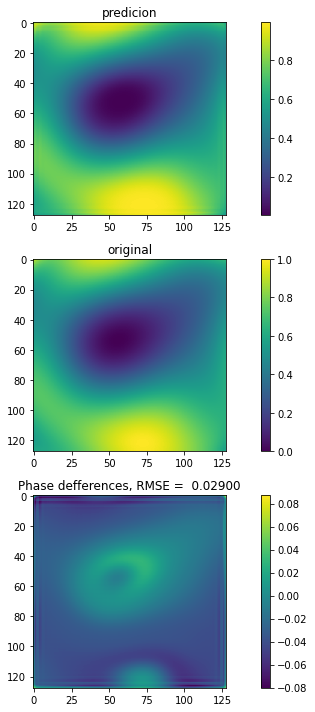

In [ ]:
plt.figure(figsize = (10,10))
i = 5
j = 10
plt.subplot(3,1,1)
prediction = loss["prediction"][i].cpu().detach().numpy()

#prediction = (prediction - np.min(prediction))/(np.max(prediction) - np.min(prediction)) 
plt.imshow(prediction)
plt.title("predicion")

plt.colorbar()

plt.subplot(3,1,2)
original = loss["original"][i].cpu().detach().numpy()
#original = (original - np.min(original))/(np.max(original) - np.min(original))
plt.imshow(original)

plt.title("original")
plt.colorbar()
#plt.colorbar()

#plt.colorbar()
plt.subplot(3,1,3)



#diff_prediction = cv2.blur(original - prediction, (5,5))
diff_prediction = original - prediction
loss_value = np.median((diff_prediction)**2)**0.5

plt.imshow(diff_prediction)
plt.title("Phase defferences, RMSE =  %.5f"%loss_value)
plt.colorbar()
#plt.colorbar()
plt.tight_layout()


plt.savefig("/content/gdrive/My Drive/ao_prediction/history/%s_predict_example.png"%model_name)

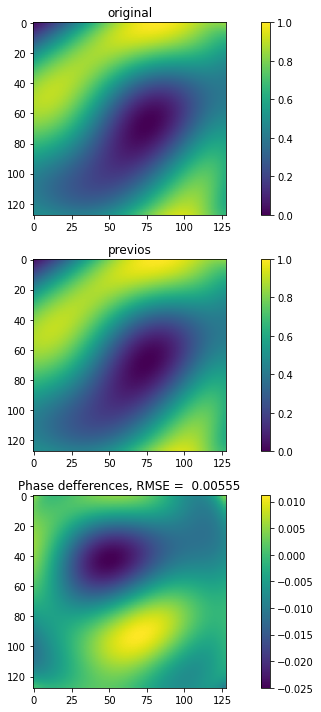

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
original = batch[i,-1].detach().numpy().reshape(128,128)
#original = (original - np.min(original))/(np.max(original) - np.min(original))
plt.imshow(original)

plt.colorbar()
plt.title("original")
plt.subplot(3,1,2)
previos = batch[i, -2].detach().numpy().reshape(128,128)
#previos = (previos - np.min(previos))/(np.max(previos) - np.min(previos))
plt.imshow(previos)

plt.colorbar()
plt.title("previos")
plt.subplot(3,1,3)
diff = original - previos

loss_value = np.median((original -previos )**2)**0.5

plt.imshow(diff)
plt.colorbar()
plt.title("Phase defferences, RMSE =  %.5f"%loss_value)
plt.tight_layout()


plt.savefig("/content/gdrive/My Drive/ao_prediction/history/%s_deffer_example.png"%model_name)

### SPEED TEST

In [ ]:
%%time
pic_count = 0
for i,batch in enumerate(train_data):
  if i == 3: break
  for dar in batch:
    model.training_step(dar.reshape(1,10,128,128,1).to("cuda"), i)
    pic_count+=1
print(pic_count)

In [ ]:
4000/30

In [ ]:
1
2
with open("/content/gdrive/My Drive/big-big-data/full_dataaset.pickle", "r") as read_file:
    data = json.load(read_file)

In [ ]:
import pickle
with open( '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mixed3_100x100.pickle', 'rb') as f:
  data_new = pickle.load(f)

In [ ]:
np.asarray(data_new[0]).shape

img1 = np.asarray(data_new[0])[:10000,0]
img2 = np.asarray(data_new[0])[:10000,1]

phase = np.asarray(data_new[1])[:10000]
coeffs =np.asarray(data_new[2])

In [ ]:
with open( '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mixed3_100x100.pickle', 'wb') as f:
    pickle.dump((img1, img2, phase, coeffs), f)

In [ ]:
np.asarray(data_new)[0].shape

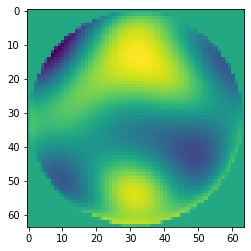

In [ ]:
plt.imshow(data_new[2].reshape(64,64))

In [ ]:
plt.imshow(data_new[0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
data_new[2].shape

In [ ]:
np.asarray(data_new[2]).shape

In [ ]:
phase = phase.reshape(10000, 64, 64)